In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

torch.set_printoptions(sci_mode = False)

# Convention

- The two input dimensions are called x1 and x2. In the general cartesian setting this is referred to as x and y.
- The two output dimensions, that jointly make up the velocity vector are referred to as y1 and y2. In other settings this is referred to as the u and v component of velocity. 

# Function

In [8]:
def input_output_function(X1, X2, a = 0.01):
    """Applies determinisitic function to input data.
    Works on grid data or training data.

    Args:
        X1 (torch.Size([N_grid, N_grid])): X1 grid, or torch.Size([N_train, 1])
        X2 (torch.Size([N_grid, N_grid])): X2 grid or torch.Size([N_train, 1])
        a (float, optional): _description_. Defaults to a.

    Returns:
        Y1 (torch.Size([N_grid, N_grid])): Y1 grid
        Y2 (torch.Size([N_grid, N_grid])): Y2 grid
    """
    # element-wise multiplication, computed once
    X1X2 = torch.mul(X1, X2)
    # element-wise exponentiation and sin/cos
    Y1 = torch.exp(-a * X1X2) * ((a * X1 * torch.sin(X1X2)) - (X1 * torch.cos(X1X2)))
    Y2 = torch.exp(-a * X1X2) * ((X2 * torch.cos(X1X2)) - (a * X2 * torch.sin(X1X2)))
    # note: transpose output of np implementation
    return Y1, Y2

In [28]:
# N in x1 and x2 direction (square grid)
N_x = 20
N_grid = N_x * N_x

# vectors - torch.Size([20])
x1 = torch.linspace(0, 4, N_x)
x2 = torch.linspace(0, 4, N_x)

# generate two meshgrids
X1, X2 = torch.meshgrid(x1, x2)

### CALL FUNCTION ###
Y1, Y2 = input_output_function(X1, X2)

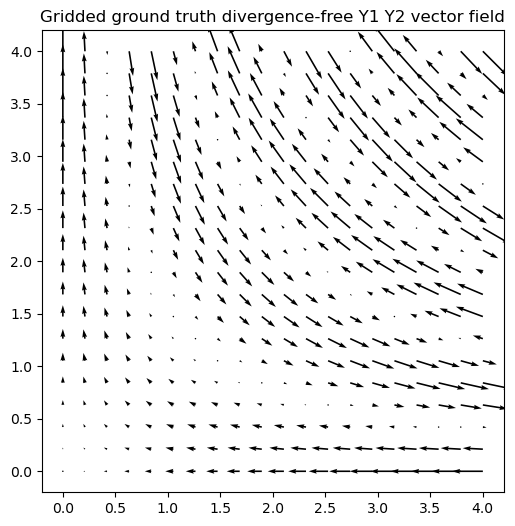

In [34]:
### PLOT ###
fig, ax = plt.subplots(figsize = (6, 6))

# fix quiver parameters for consistent visualisation across axis
quiver_width = 0.0035
quiver_scale = 60

# quiver plot visualises 2 in 1 
ax.quiver(X1, X2, Y1, Y2, color = 'black', width = quiver_width, scale = quiver_scale)

ax.set_aspect('equal')
plt.title('Gridded ground truth divergence-free Y1 Y2 vector field')
# noise free

plt.show()

### Check divergence free property

In [301]:
# np.gradient default step size is 1 but we want the actual step size of the grid
delta_x1, delta_x2 = X1[1, 0] - X1[0, 0], X2[0, 1] - X2[0, 0]

print(f"True spacing between grid values: ({delta_x1:.3f}, {delta_x2:.3f})")

# Ordering of axis is counter-intuitive!!!
divergence = np.gradient(Y1, delta_x1, axis = 0) + np.gradient(Y2, delta_x2, axis = 1)

# We are exacly reprocing matlab code
print("Highest abolute divergence value: ", np.max(np.abs(divergence)))
print("Highest abolute divergence value without outermost boarder: ", np.max(np.abs(divergence[1:-1, 1:-1])))
# symmetry: as a sum it is non divergent: cancelling out

print("Sum of all divergence values balances out to zero: ", np.sum(divergence))

True spacing between grid values: (0.211, 0.211)
Highest abolute divergence value:  4.056947
Highest abolute divergence value without outermost boarder:  0.54007006
Sum of all divergence values balances out to zero:  -4.7683716e-07


### Torch does not do exactly the same as numpy

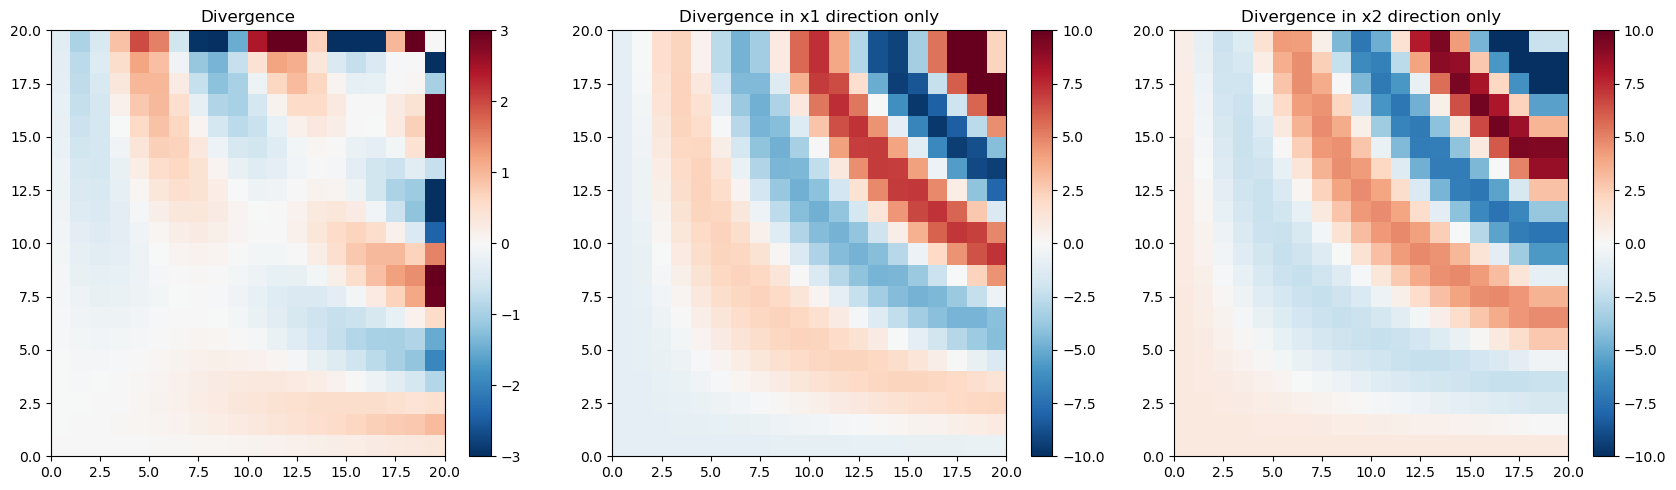

In [299]:
# Compute gradients (finite differences)
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 3, figsize = (17, 5))

combined_color_max = 3
color_max = 10

# The last row can't be compared against anything - torch.Size([19, 20])
grad_Y1 = torch.diff(Y1, dim = 0) / delta_x1
torch_y1_gradient = torch.cat((grad_Y1, grad_Y1[-1, :].unsqueeze(0)), dim = 0)

# The last column can't be compared against anything - torch.Size([20, 19])
grad_Y2 = torch.diff(Y2, dim = 1) / delta_x2
# create copy of last column and append it to the right
torch_y2_gradient = torch.cat((grad_Y2, grad_Y2[:, -1].unsqueeze(1)), dim = 1)

torch_div = torch_y1_gradient + torch_y2_gradient

# First subplot: Divergence in x1 direction
c1 = axs[0].pcolormesh(torch_div, cmap = 'RdBu_r', vmin = - combined_color_max, vmax = combined_color_max)
fig.colorbar(c1, ax = axs[0])
axs[0].set_title('Divergence')

# First subplot: Divergence in x1 direction
c2 = axs[1].pcolormesh(torch_y1_gradient, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
fig.colorbar(c2, ax = axs[1])
axs[1].set_title('Divergence in x1 direction only')

# Second subplot: Divergence in x2 direction
c3 = axs[2].pcolormesh(torch_y2_gradient, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
fig.colorbar(c3, ax = axs[2])
axs[2].set_title('Divergence in x2 direction only')

# Show the plot
plt.tight_layout()
plt.show()

note copied rows/columns

# Numpy approach

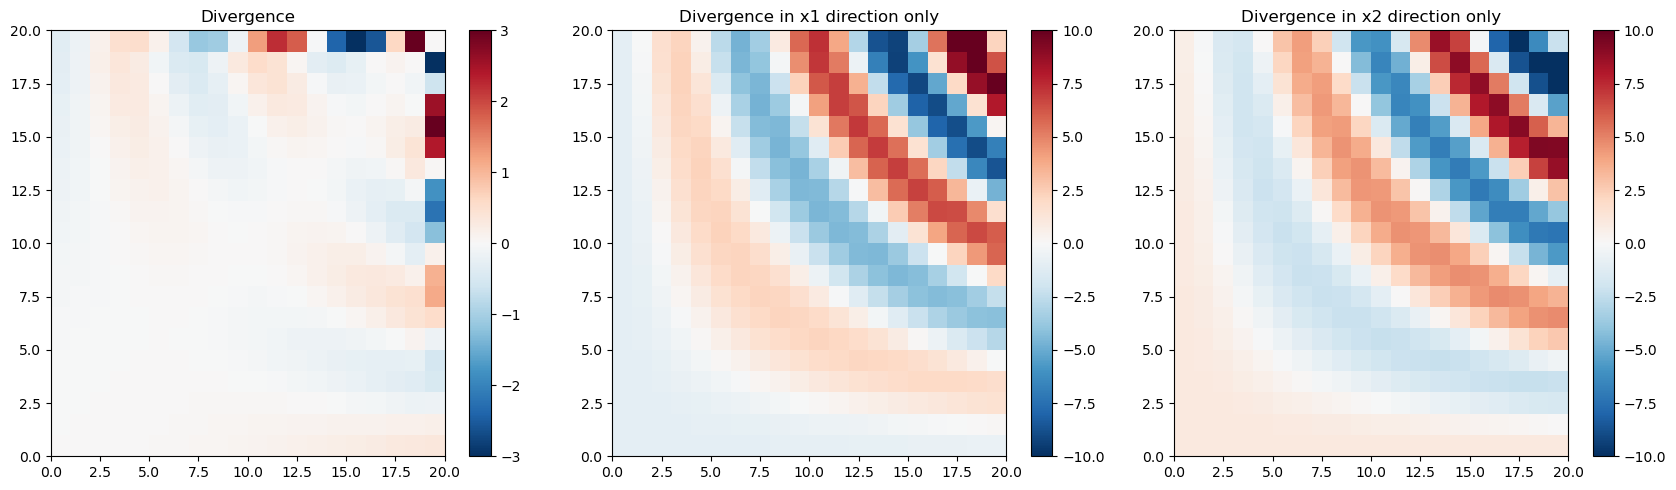

In [298]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 3, figsize = (17, 5))

combined_color_max = 3
color_max = 10

numpy_y1_gradient = np.gradient(Y1, delta_x1, axis = 0)
# same as y1_gradient = np.gradient(Y1, 1, axis = 0) / delta_x1
numpy_y2_gradient = np.gradient(Y2, delta_x2, axis = 1)

numpy_div = numpy_y1_gradient + numpy_y2_gradient

# First subplot: Divergence in x1 direction
c1 = axs[0].pcolormesh(numpy_div, cmap = 'RdBu_r', vmin = - combined_color_max, vmax = combined_color_max)
fig.colorbar(c1, ax = axs[0])
axs[0].set_title('Divergence')

# First subplot: Divergence in x1 direction
c2 = axs[1].pcolormesh(numpy_y1_gradient, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
fig.colorbar(c2, ax = axs[1])
axs[1].set_title('Divergence in x1 direction only')

# Second subplot: Divergence in x2 direction
c3 = axs[2].pcolormesh(numpy_y2_gradient, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
fig.colorbar(c3, ax = axs[2])
axs[2].set_title('Divergence in x2 direction only')

# Show the plot
plt.tight_layout()
plt.show()

In [252]:
# Numpy row zero is bottom row, torch row zero is top row
numpy_div[0, :]
# Numpy row -1 is top row, torch row -1 is bottom row
numpy_div[-1, :]

# Numpy column zero is leftmost column
numpy_div[:, 0]
# Numpy column -1 is rightmost column
numpy_div[:, -1]

array([ 0.3470878 ,  0.18476816, -0.15482557, -0.47715592, -0.5248932 ,
       -0.14193678,  0.5550289 ,  1.136466  ,  1.0736911 ,  0.14244795,
       -1.2620993 , -2.2139468 , -1.8220592 ,  0.04253197,  2.4102058 ,
        3.6541321 ,  2.5668306 , -0.61656094, -4.056947  ,  0.        ],
      dtype=float32)

# Fixed example

- only 5 data points
- to reproduce

In [325]:
sigma_n = torch.tensor([0.01])
# Flattenting the grid
X1_test = X1.reshape(-1, 1)
X2_test = X2.reshape(-1, 1)

In [336]:
# Capitalisation because this is artificially 2D data
X1_train_fixed = torch.tensor([0.1, 3.5, 0.6, 1.0, 2.0]).unsqueeze(-1)
X2_train_fixed = torch.tensor([0.1, 2.7, 3.9, 3.6, 1.4]).unsqueeze(-1)

# unsqueeze for explicit last dim - torch.Size([5, 1])
Y1_train_fixed_noisefree, Y2_train_fixed_noisefree = input_output_function(X1_train_fixed, X2_train_fixed)

# Add noise (small normal)
Y1_train_fixed_noisy = Y1_train_fixed_noisefree + torch.randn(Y1_train_fixed_noisefree.shape) * sigma_n
Y2_train_fixed_noisy = Y2_train_fixed_noisefree + torch.randn(Y2_train_fixed_noisefree.shape) * sigma_n

# Concatenate along the first axis so that first half is Y1 and second half is Y2
Y_train_fixed_noisy_flat = torch.cat((Y1_train_fixed_noisy, Y2_train_fixed_noisy), dim = 0)

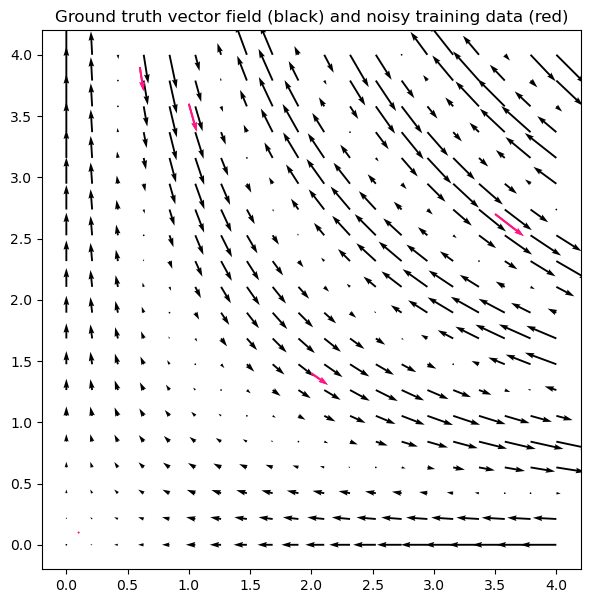

In [327]:
# Quiver plot paramaters are automatically adjusted and thus differ for both layers so we unify this
quiver_width = 0.0035
quiver_scale = 60

# creating plot
fig, ax = plt.subplots(figsize = (7, 7))

# quiver plot visualises 2 in 1 
ax.quiver(X1, X2, Y1, Y2, width = quiver_width, scale = quiver_scale)
ax.quiver(X1_train_fixed, X2_train_fixed, Y1_train_fixed_noisefree, Y2_train_fixed_noisefree, color = 'red', width = quiver_width, scale = quiver_scale)
ax.quiver(X1_train_fixed, X2_train_fixed, Y1_train_fixed_noisy, Y2_train_fixed_noisy, color = 'deeppink', width = quiver_width, scale = quiver_scale)

ax.set_aspect('equal')
plt.title('Ground truth vector field (black) and noisy training data (red)')
 
# show plot
plt.show()

In [329]:
def divergence_free_se_kernel(X1_rows, X2_rows, X1_columns, X2_columns, 
                              sigma_f = torch.tensor([0.7]), l = torch.tensor([0.7])):
    # Calculate the Euclidean distance between all pairs of points
    # previous approach yielded negative values as well
    # torch.Size([n_train, n_test])
    X1_dist = torch.cdist(X1_rows, X1_columns)
    # torch.Size([n_train, n_test])
    X2_dist = torch.cdist(X2_rows, X2_columns)

    # torch.Size([n_train, n_test])
    upper_left = (1 - X2_dist.square().div(l**2)).div(l**2)

    # elementwise multiplication and division by scalar
    # Matlab version has negative values here! 
    upper_right = torch.mul(X1_dist, X2_dist).div(l**4)
    lower_left = upper_right
    lower_right = (1 - X1_dist.square().div(l**2)).div(l**2)

    # Concatenate upper and lower blocks columnswise, and then concatenate them rowwise
    # torch.Size([2 * n_train, 2 * n_test])
    block = torch.cat((torch.cat((upper_left, upper_right), 1), torch.cat((lower_left, lower_right), 1)), 0)

    # torch.Size([2 * n_train, 2 * n_test])
    # elementwise multiplication
    K = sigma_f.square() * block.mul((X1_dist.square() + X2_dist.square()).div(-2 * l**2).exp().tile(2, 2))

    return K

In [330]:
K_train_train = divergence_free_se_kernel(
    X1_train_fixed, 
    X2_train_fixed, 
    X1_train_fixed, 
    X2_train_fixed)

# Add noise to the diagonal
K_train_train_noisy = K_train_train + torch.eye(K_train_train.shape[0]) * sigma_n**2

# torch.Size([2 * n_train, 2 * n_test])
K_train_test = divergence_free_se_kernel(
    X1_train_fixed, 
    X2_train_fixed, 
    X1_test, 
    X2_test)

# torch.Size([2 * n_test, 2 * n_train])
K_test_train = K_train_test.mT

K_test_test = divergence_free_se_kernel(
    X1_test, 
    X2_test, 
    X1_test, 
    X2_test)

In [331]:
# Determine L - torch.Size([2 * n_train, 2 * n_train])
L = torch.linalg.cholesky(K_train_train_noisy, upper = False)
# L.T \ (L \ y) in one step - torch.Size([2 * n_train, 1])
alpha = torch.cholesky_solve(Y_train_fixed_noisy_flat, L, upper = False)

# matrix multiplication
# torch.Size([2 * n_test, 2 * n_train]) * torch.Size([2 * n_train, 1])
predictive_mean = torch.matmul(K_test_train, alpha)
# predicitive_covariance = 

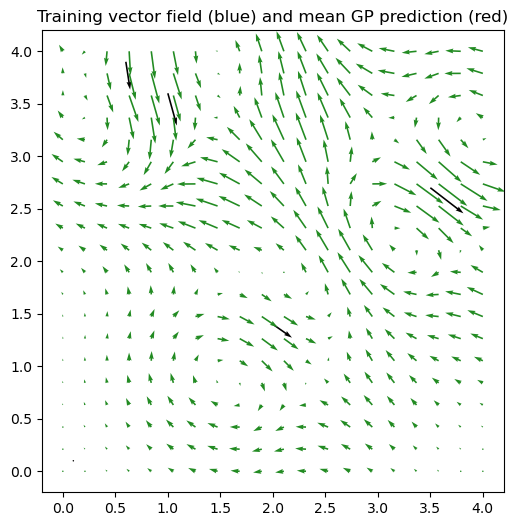

In [335]:
# creating plot
fig, ax = plt.subplots(figsize = (6, 6))

# grond truth vector field
# ax.quiver(X1, X2, Y1, Y2, color = 'black', width = quiver_width)
ax.quiver(X1_train_fixed, X2_train_fixed, Y1_train_fixed_noisefree, Y2_train_fixed_noisefree, color = 'black', width = quiver_width)
ax.quiver(X1, X2, predictive_mean.reshape(2, 20, 20)[0,:,:], predictive_mean.reshape(2, 20, 20)[1,:,:], color = 'forestgreen', width = quiver_width)

ax.set_aspect('equal')
plt.title('Training vector field (blue) and mean GP prediction (red)')
# show plot
plt.show()